https://medium.com/@naveed88375/tensorflow-custom-training-loop-8d1e56d1817e

In [ ]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]

clearall()

In [ ]:
import time,sys,os
from scipy.stats import norm
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import tensorflow as tf,keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import legacy as legacy_optimizers
import pandas as pd
from keras.models import Sequential,Model
from keras.layers import Dense,Input,LeakyReLU
from keras.initializers import TruncatedNormal
from keras.activations import tanh, linear, relu

In [ ]:
def callPriceBlackScholes(S, K, T, r, sigma):
  d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
  d2 = d1-sigma*np.sqrt(T)
  return S*norm.cdf(d1)-norm.cdf(d2)*K*np.exp(-r*T)

def callDeltaBlackScholes(S, K, T, r, sigma):
  d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
  return norm.cdf(d1)


In [ ]:
S = 20000           # Spot Price
vol = 0.6           # Volatility
K = 20000           # Strike Price
T = 0.1             # Horizon
t = 100             # Number of time steps
r = 0.02            # Risk-free interest rate
sigma = 0.6         # Implied volatility

dt = T/t
taux = np.linspace(0, T, t+1)
priceBS = callPriceBlackScholes(S, K, T, 0.0, sigma)

In [ ]:
def Neural_Network():
    inputs = Input(shape=(2,))

    x = Dense(64, activation=LeakyReLU(alpha=0.01),bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True)(inputs)
    x = Dense(64, activation=LeakyReLU(alpha=0.01),bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True)(x)
    x = Dense(64, activation=LeakyReLU(alpha=0.01),bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True)(x)
    x = Dense(64, activation=LeakyReLU(alpha=0.01),bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True)(x)
    x = Dense(64, activation=LeakyReLU(alpha=0.01),bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True)(x)
    x = Dense(64, activation=tanh,bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True)(x)

    outputs = Dense(1, activation=tanh, bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True,name='predictions')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
mlp = [Neural_Network() for _ in range(t + 1)]

def run_nn(mat_index, mlp, inputs):
    return mlp[mat_index](inputs)

def Deep_Hedging(n_path):
    X = tf.tile(tf.reshape(0.0, [1,-1]), [n_path,1])
    delta = tf.tile( tf.reshape(0.0, [1,-1]), [n_path,1])
    stochInt = tf.tile(tf.reshape(0.0, [1,-1]), [n_path,1])

    for i in range(t):
        G = tf.random.normal(tf.shape(X), mean=0, stddev=1)
        deltaX = -0.5 * vol**2 * dt + vol * tf.sqrt(dt) * G
        deltaX=tf.reshape(deltaX,[n_path,1])
        inputs = tf.concat([X, delta], axis=1)
        delta = run_nn(i,mlp,inputs)
        stochInt = stochInt + delta*S*(tf.exp(X+deltaX)-tf.exp(X))
        X = X + deltaX

    payoff = tf.maximum(S*tf.exp(X)-K, 0)
    predicted=priceBS + stochInt
    Actual= payoff
    hedgingError = priceBS + stochInt - payoff
    mse = tf.reduce_mean(tf.square(hedgingError))
    return mse, hedgingError,priceBS + stochInt,payoff

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

@tf.function(
input_signature=[
    tf.TensorSpec(shape=None, dtype=tf.int32),
],
)

def train_step(n_paths):
    with tf.GradientTape() as tape:
        loss_value,_,_,_ = Deep_Hedging(n_paths)
    trainable_weights = [model.trainable_weights for model in mlp]
    grads = tape.gradient(loss_value, trainable_weights)
    flat_grads = [item for sublist in grads for item in sublist]
    flat_weights = [item for sublist in trainable_weights for item in sublist]
    optimizer.apply_gradients(zip(flat_grads, flat_weights))
    return loss_value

n_path = tf.constant(256)
maxIter = 10000

start_time = time.time()

for k in range(maxIter):
    print('Start of epoch %d' % (k,))
    loss_value = train_step(n_path)
    print(loss_value)

print("--- loss function: ", np.round(loss_value.numpy(), 6), "    ---")
print("---", time.time() - start_time, "seconds ---")

Start of epoch 0


Streaming output truncated to the last 5000 lines.
Start of epoch 7501
tf.Tensor(23395.54, shape=(), dtype=float32)
Start of epoch 7502
tf.Tensor(22137.484, shape=(), dtype=float32)
Start of epoch 7503
tf.Tensor(29381.812, shape=(), dtype=float32)
Start of epoch 7504
tf.Tensor(34388.4, shape=(), dtype=float32)
Start of epoch 7505
tf.Tensor(30791.004, shape=(), dtype=float32)
Start of epoch 7506
tf.Tensor(23913.754, shape=(), dtype=float32)
Start of epoch 7507
tf.Tensor(27148.633, shape=(), dtype=float32)
Start of epoch 7508
tf.Tensor(25026.2, shape=(), dtype=float32)
Start of epoch 7509
tf.Tensor(29102.04, shape=(), dtype=float32)
Start of epoch 7510
tf.Tensor(31300.514, shape=(), dtype=float32)
Start of epoch 7511
tf.Tensor(27729.04, shape=(), dtype=float32)
Start of epoch 7512
tf.Tensor(23639.324, shape=(), dtype=float32)
Start of epoch 7513
tf.Tensor(27398.73, shape=(), dtype=float32)
Start of epoch 7514
tf.Tensor(27905.3, shape=(), dtype=float32)
Start of epoch 7515
tf.Tensor(23404

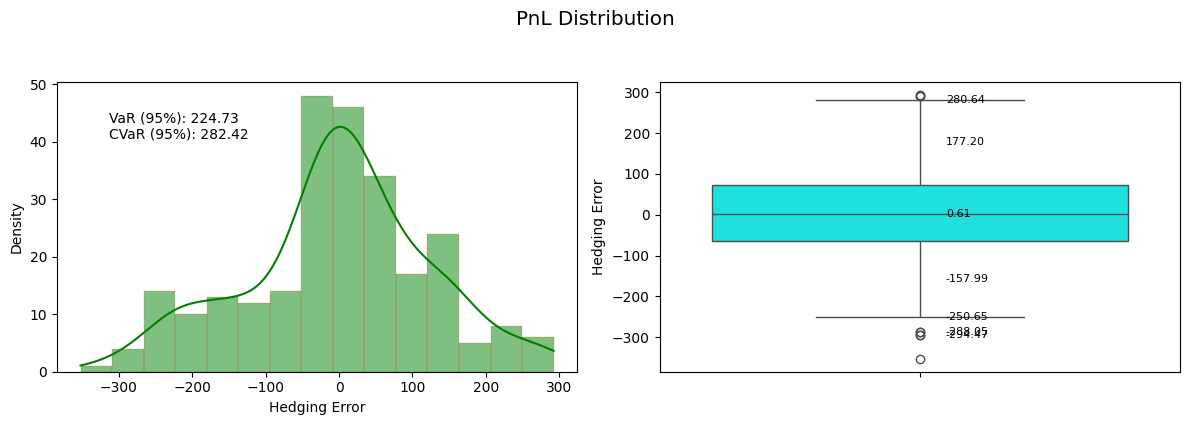

In [ ]:
PnL = Deep_Hedging(n_path)[1]

flattened_PnL = np.ravel(PnL)
downsampled_PnL = np.random.choice(flattened_PnL, size=n_path)

var_95 = norm.ppf(0.95, loc=np.mean(PnL), scale=np.std(PnL))
tail_loss = norm.expect(lambda x: x, loc=np.mean(PnL), scale=np.std(PnL), lb=var_95)
cvar_95 = (1 / (1 - 0.95)) * tail_loss

plt.figure(figsize=(12, 4))
# Histogram
plt.subplot(1, 2, 1)
sns.histplot(downsampled_PnL, kde=True, color="green", linewidth=.1,edgecolor='red')
plt.text(0.1, 0.9, f"VaR (95%): {var_95:.2f}\nCVaR (95%): {cvar_95:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel('Hedging Error')
plt.ylabel('Density')

# Box plot
plt.subplot(1, 2, 2)
box_plot = sns.boxplot(downsampled_PnL, color="cyan")
plt.ylabel('Hedging Error')

for line in box_plot.lines:
    y = line.get_ydata()
    x = line.get_xdata()
    if len(y) == 2:
        plt.text(x.mean() + 0.05, y.mean(), f"{y.mean():.2f}", ha='left', va='center', fontsize=8)
    else:
        plt.text(x[1] + 0.05, y[1], f"{y[1]:.2f}", ha='left', va='center', fontsize=8)
        plt.text(x[0] + 0.05, y[0], f"{y[0]:.2f}", ha='left', va='center', fontsize=8)

plt.suptitle('PnL Distribution', x=0.5, y=1.05, ha='center', fontsize='x-large')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import norm

# Calculate and print mean and standard deviation
print("Mean:", np.mean(PnL))
print("Standard Deviation:", np.std(PnL))
skewness = skew(PnL)[0]
kurt = kurtosis(PnL)[0]

# Print the results
print("Skewness:", skewness)
print("Kurtosis:", kurt)
# Calculate and print percentiles
print("Percentile 5:", np.percentile(PnL, 5))
print("Percentile 95:", np.percentile(PnL, 95))

# Calculate and print Value at Risk (VaR) at 95% confidence level
VaR_95 = norm.ppf(0.95, loc=np.mean(PnL), scale=np.std(PnL))
print("VaR at 95% confidence level:", VaR_95)

# Calculate tail loss for CVaR
tail_loss = norm.expect(lambda x: x, loc=np.mean(PnL), scale=np.std(PnL), lb=VaR_95)

# Calculate and print Conditional Value at Risk (CVaR) at 95% confidence level
CVaR_95 = (1 / (1 - 0.95)) * tail_loss
print("CVaR at 95% confidence level:", CVaR_95)

Mean: -2.339734
Standard Deviation: 138.05127
Skewness: 0.04946623
Kurtosis: 0.09995723
Percentile 5: -228.037841796875
Percentile 95: 227.84860229492188
VaR at 95% confidence level: 224.7343973162782
CVaR at 95% confidence level: 282.42038767731543


In [ ]:
size = 100
arraySpot = np.linspace(0.6 * S, 1.4 * S, size)
arraySpot = arraySpot.astype(np.float32)
arraySpot = np.reshape(arraySpot, [-1, 1])


arrayDelta = np.zeros(size)
arrayDelta = arrayDelta.astype(np.float32)
arrayDelta = np.reshape(arrayDelta, [-1, 1])

for i in range(t):
    fig, ax = plt.subplots()
    ax.plot(arraySpot, run_nn(i,mlp,np.concatenate((np.log(arraySpot / S), arrayDelta), axis=1)), label="Neural Network")
    ax.plot(arraySpot, callDeltaBlackScholes(arraySpot,K,T-taux[i],0.0,sigma), label="Delta Black & Scholes")
    ax.set_title("t =  {}".format(np.round(taux[i], 4)))
    ax.set_xlabel("Spot")
    ax.set_ylabel("Hedge")
    ax.legend()
    ax.grid()

    arrayDelta = run_nn(i,mlp,np.concatenate((np.log(arraySpot / S), arrayDelta), axis=1))
    plt.show()


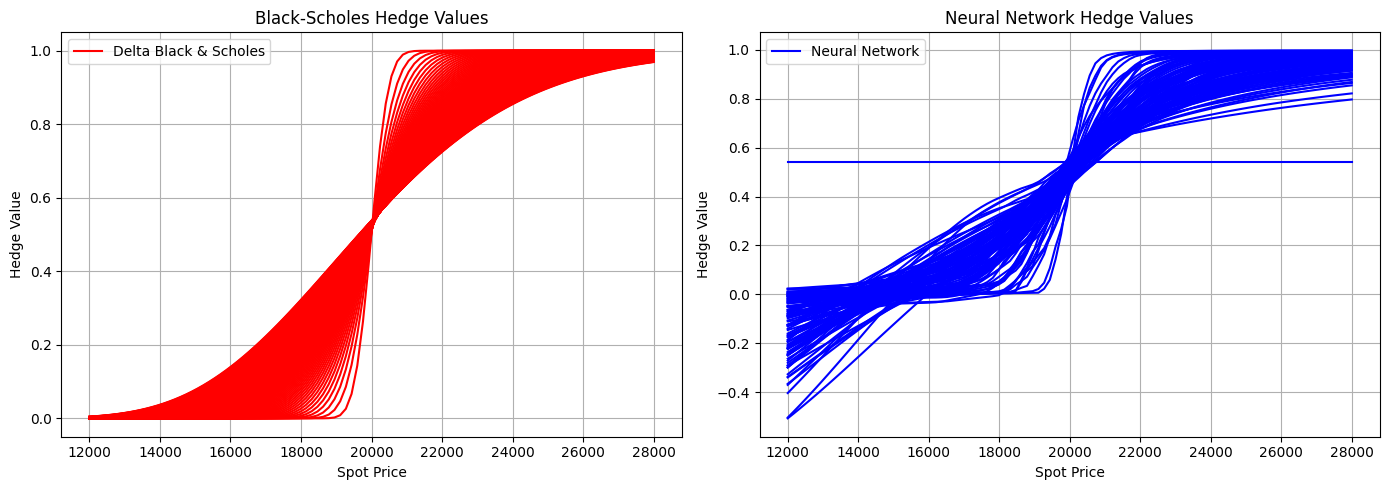

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate arraySpot and arrayDelta
arraySpot = np.linspace(0.6 * S, 1.4 * S, size).astype(np.float32).reshape(-1, 1)
arrayDelta = np.zeros(size, dtype=np.float32).reshape(-1, 1)

# Initialize a list to store hedge values for each timestep
hedges_nn = []
hedges_bs = []

# Loop over timesteps
for i in range(t):
    # Calculate hedge values for Neural Network and Black-Scholes
    hedge_nn = run_nn(i, mlp, np.concatenate((np.log(arraySpot / S), arrayDelta), axis=1))
    hedge_bs = callDeltaBlackScholes(arraySpot, K, T - taux[i], 0.0, sigma)

    # Append hedge values to the lists
    hedges_nn.append(hedge_nn)
    hedges_bs.append(hedge_bs)

# Create a figure with two subplots
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Black-Scholes hedge values
for i in range(t):
    ax2.plot(arraySpot, hedges_bs[i], color='red', linestyle='-', label="Delta Black & Scholes" if i == 0 else None)
ax2.set_title("Black-Scholes Hedge Values")
ax2.set_xlabel("Spot Price")
ax2.set_ylabel("Hedge Value")
ax2.legend()
ax2.grid()

# Plot Neural Network hedge values
for i in range(t):
    ax1.plot(arraySpot, hedges_nn[i], color='blue', linestyle='-', label="Neural Network" if i == 0 else None)
ax1.set_title("Neural Network Hedge Values")
ax1.set_xlabel("Spot Price")
ax1.set_ylabel("Hedge Value")
ax1.legend()
ax1.grid()


plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider

# Generate arraySpot and arrayDelta
arraySpot = np.linspace(0.6 * S, 1.4 * S, size).astype(np.float32).reshape(-1, 1)
arrayDelta = np.zeros(size, dtype=np.float32).reshape(-1, 1)

# Initialize a list to store hedge values for each timestep
hedges_nn = []
hedges_bs = []

# Loop over timesteps
for i in range(t):
    # Calculate hedge values for Neural Network and Black-Scholes
    hedge_nn = run_nn(i, mlp, np.concatenate((np.log(arraySpot / S), arrayDelta), axis=1))
    hedge_bs = callDeltaBlackScholes(arraySpot, K, T - taux[i], 0.0, sigma)

    # Append hedge values to the lists
    hedges_nn.append(hedge_nn)
    hedges_bs.append(hedge_bs)

# Define a function to plot hedge values for a given time step
def plot_hedges(time_step):
    plt.figure(figsize=(6, 4))
    plt.plot(arraySpot, hedges_nn[time_step], color='blue', label='Neural Network')
    plt.plot(arraySpot, hedges_bs[time_step], color='red', label='Delta Black & Scholes')
    plt.title(f'Hedge Values Comparison - Time Step {time_step}')
    plt.xlabel('Spot Price')
    plt.ylabel('Hedge Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a slider to select the time step
slider = IntSlider(min=0, max=t-1, step=1, value=0)

# Use the interact function to connect the slider to the plot function
interact(plot_hedges, time_step=slider)


interactive(children=(IntSlider(value=0, description='time_step', max=99), Output()), _dom_classes=('widget-in…

<function __main__.plot_hedges(time_step)>

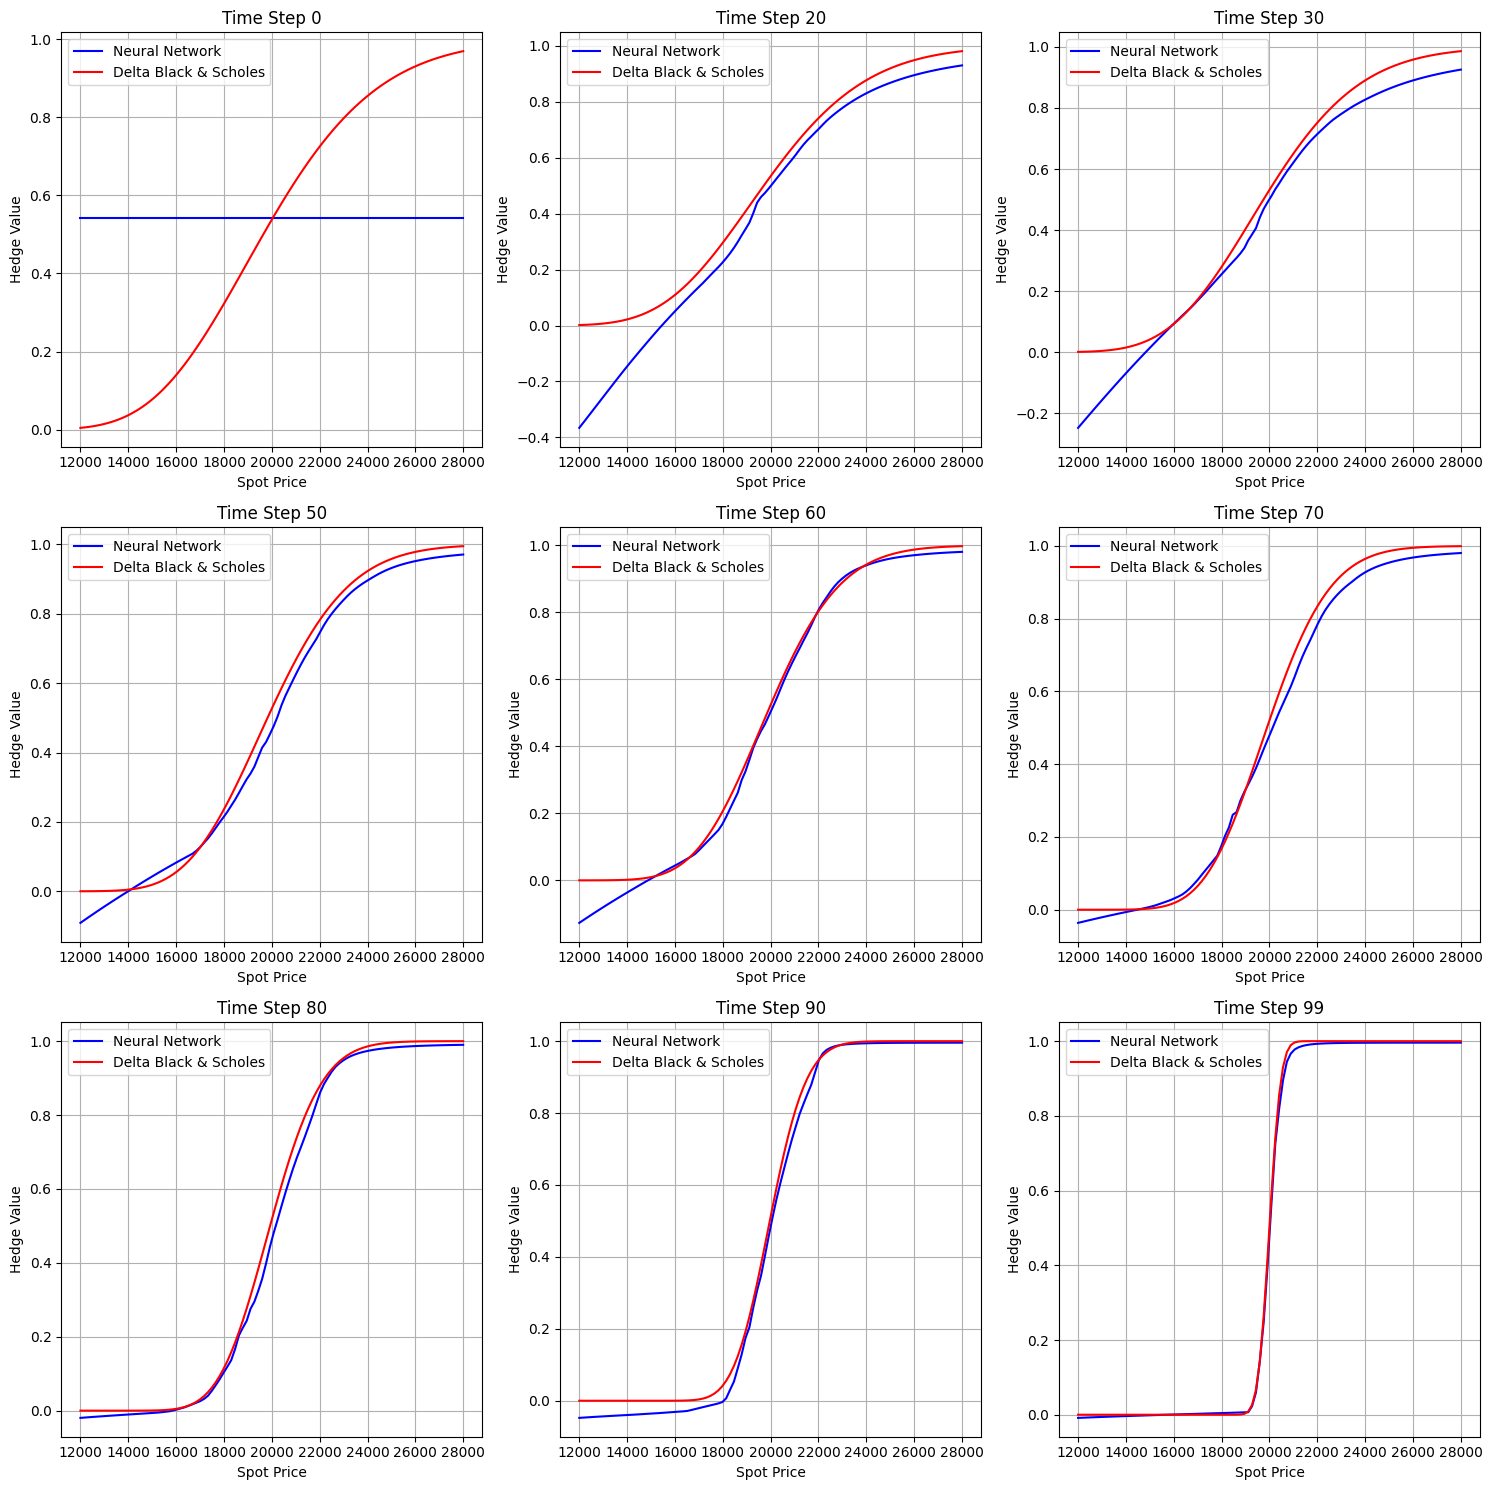

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate arraySpot and arrayDelta
arraySpot = np.linspace(0.6 * S, 1.4 * S, size).astype(np.float32).reshape(-1, 1)
arrayDelta = np.zeros(size, dtype=np.float32).reshape(-1, 1)

# Initialize lists to store hedge values for each timestep
hedges_nn = []
hedges_bs = []

# Loop over timesteps
for i in range(t):
    # Calculate hedge values for Neural Network and Black-Scholes
    hedge_nn = run_nn(i, mlp, np.concatenate((np.log(arraySpot / S), arrayDelta), axis=1))
    hedge_bs = callDeltaBlackScholes(arraySpot, K, T - taux[i], 0.0, sigma)

    # Append hedge values to the lists
    hedges_nn.append(hedge_nn)
    hedges_bs.append(hedge_bs)

# Define a function to plot hedge values for a given time step
def plot_hedges(ax, time_step):
    ax.plot(arraySpot, hedges_nn[time_step], color='blue', label='Neural Network')
    ax.plot(arraySpot, hedges_bs[time_step], color='red', label='Delta Black & Scholes')
    ax.set_title(f'Time Step {time_step}')
    ax.set_xlabel('Spot Price')
    ax.set_ylabel('Hedge Value')
    ax.legend()
    ax.grid(True)

# Specify the time steps to plot
time_steps = [0, 20, 30, 50, 60, 70, 80, 90, 99]

# Create subplots arranged in a grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Plot hedge values for specified time steps
for i, step in enumerate(time_steps):
    row = i // 3
    col = i % 3
    plot_hedges(axes[row, col], step)

# Adjust layout
plt.tight_layout()
plt.show()
